<a href="https://colab.research.google.com/github/dannesbitt/GAIA-Agent/blob/main/GAIA_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q langgraph langchain_openai langchain_huggingface google-cloud-speech beautifulsoup4 pytube openai-whisper google-auth-oauthlib google-auth-httplib2 google-api-python-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 

Processing task_id: 8e867cd7-cff9-4e6c-867a-ff5ddc2550be
Question: How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
File Name: 
execute_tool :  web_search
execute_tool query:  Mercedes Sosa discography site:wikipedia.org
Tool call result: Title: Mercedes Sosa - Wikipedia
Snippet: Haydée Mercedes "La Negra" Sosa was an Argentine singer who was popular throughout Latin America and many countries outside the region. With her roots in ...
Full Content: Mercedes Sosa - Wikipedia Jump to content Main menu Main menu move to sidebar hide Navigation Main page Contents Current events Random article About Wikipedia Contact us Contribute Help Learn to edit Community portal Recent changes Upload file Special pages Search Search Appearance Donate Create account Log in Personal tools Donate Create account Log in Pages for logged out editors learn more Contributions Talk Contents move to sidebar hide (Top
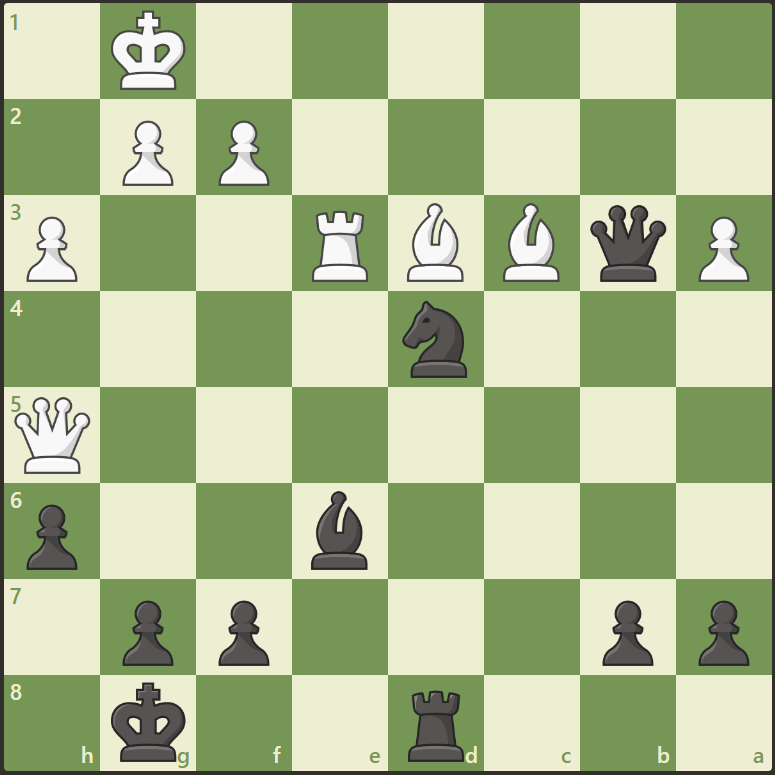

In [9]:
import os
import re
import requests
import json
import base64
from typing import TypedDict, List
from openai import OpenAI
from langgraph.graph import Graph, END
from google.colab import userdata
from urllib.parse import urlparse, parse_qs
from google.cloud import speech_v1p1beta1 as speech
from bs4 import BeautifulSoup
import pandas as pd
import pytube
import whisper
import requests
from google.auth import default
import string
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# Set up OpenAI client
OPEN_API_KEY = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=OPEN_API_KEY)

# Set up Google API key and Custom Search Engine ID for web search
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
GOOGLE_CSE_ID = userdata.get('GOOGLE_CSE_ID')  # Custom Search Engine ID

fetch_full_content = True  # Set to True to fetch full content of search results
max_content_length = 30000  # Max number of characters to parse from web content

# Define the state structure
class State(TypedDict):
    messages: List[dict]
    tool_calls: List[dict]
    final_response: str
    needs_tool_call: bool

# Define available tools, including the new "web_search" tool
tools = [
    # Other tools may be present here...
    {
        "type": "function",
        "function": {
            "name": "web_search",
            "description": "Perform a web search to find information. Can optionally fetch full content of the top 3 results, truncated to a specified character limit.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The search query"
                    },
                    "fetch_full_content": {
                        "type": "boolean",
                        "description": "Whether to fetch and include full content of the top 3 search results. Defaults to False."
                    },
                    "max_content_length": {
                        "type": "integer",
                        "description": "Maximum number of characters to include from each page's content. Defaults to 5000."
                    }
                },
                "required": ["query"]
            }
        }
    }
    # Other tools...
]

def execute_tool(tool_call):
    """Executes the specified tool and returns the result."""
    print("execute_tool : ", tool_call.function.name)
    if tool_call.function.name == "get_weather":
        return "It's sunny today."
    elif tool_call.function.name == "web_search":
        try:
            args = json.loads(tool_call.function.arguments)
            query = args["query"]
#            fetch_full_content = args.get("fetch_full_content", False)
#            max_content_length = args.get("max_content_length", 5000)  # Default to 5000 characters
            print("execute_tool query: ", query)
            api_key = GOOGLE_API_KEY
            cse_id = GOOGLE_CSE_ID
            if not api_key or not cse_id:
                return "API key or Search Engine ID not set."
            search_url = f"https://www.googleapis.com/customsearch/v1?key={api_key}&cx={cse_id}&q={query}"
            response = requests.get(search_url)
            response.raise_for_status()
            search_results = response.json()
            results = []
            for item in search_results.get('items', [])[:3]:  # Limit to top 3 results
                title = item.get('title', 'No title')
                snippet = item.get('snippet', 'No snippet')
                if fetch_full_content:
                    url = item.get('link')
                    try:
                        page_response = requests.get(url, timeout=5)
                        page_response.raise_for_status()
                        if page_response.headers.get('Content-Type', '').startswith('text/html'):
                            soup = BeautifulSoup(page_response.text, 'html.parser')
                            for script in soup(["script", "style"]):
                                script.decompose()
                            full_content = soup.get_text(separator=' ', strip=True)
                            # Truncate to max_content_length
                            if len(full_content) > max_content_length:
                                full_content = full_content[:max_content_length] + "... [Content truncated]"
                        else:
                            full_content = "Full content not available (non-HTML content)"
                    except Exception as e:
                        full_content = f"Full content not available: {str(e)}"
                    results.append(f"Title: {title}\nSnippet: {snippet}\nFull Content: {full_content}\n")
                else:
                    results.append(f"Title: {title}\nSnippet: {snippet}\n")
            return "\n---\n".join(results) if results else "No results found."
        except (json.JSONDecodeError, KeyError) as e:
            return f"Error in tool call arguments: {e}"
        except Exception as e:
            return f"Error performing web search: {e}"
    return "Tool not found."

def fetch_specific_file(task_id, file_name):
    """Fetches the content of a specific file. Returns content or path based on file type."""
    IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')
    url = f"https://agents-course-unit4-scoring.hf.space/files/{task_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        if file_name.lower().endswith('.mp3'):
            audio_path = '/content/temp_audio.mp3'
            with open(audio_path, 'wb') as f:
                f.write(response.content)
            transcript = transcribe_audio(audio_path)
            return transcript if transcript else "Transcription failed.", None
        elif file_name.lower().endswith(IMAGE_EXTENSIONS):
            image_path = f"/content/temp_image{os.path.splitext(file_name)[1]}"
            with open(image_path, 'wb') as f:
                f.write(response.content)
            return None, image_path
        elif file_name.lower().endswith('.xlsx'):
            excel_path = '/content/temp_excel.xlsx'
            with open(excel_path, 'wb') as f:
                f.write(response.content)
            try:
                df = pd.read_excel(excel_path)
                csv_content = df.to_csv(index=False)
                print("Excel file content (CSV):", csv_content[:100])
                return csv_content, None
            except Exception as e:
                print(f"Error reading Excel file {file_name}: {e}")
                return None, None
        else:
            if not response.text.strip():
                print(f"Error: Empty content received for {file_name}")
                return None, None
            else:
                print("Text file content:", response.text)
                return response.text, None
    except Exception as e:
        print(f"Error fetching file {file_name} for task_id {task_id}: {e}")
        return None, None


# Helper function to encode image to base64
def encode_image_to_base64(image_path):
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        return encoded_string
    except Exception as e:
        print(f"Error encoding image at {image_path}: {e}")
        return None

# Helper function to extract YouTube video ID from a URL (unchanged)
def extract_youtube_id(url):
    parsed = urlparse(url)
    if parsed.netloc == 'www.youtube.com' and parsed.path == '/watch':
        query = parse_qs(parsed.query)
        return query.get('v', [None])[0]
    elif parsed.netloc == 'youtu.be':
        return parsed.path[1:] if parsed.path else None
    return None

# Helper function to parse SBV caption format (unchanged)
def parse_sbv(sbv_text):
    blocks = sbv_text.strip().split('\n\n')
    transcript = []
    for block in blocks:
        lines = block.split('\n')
        if len(lines) > 1:
            transcript.append(' '.join(lines[1:]))
    return ' '.join(transcript)

def fetch_youtube_transcript(video_id, youtube_service):
    caption_list = youtube_service.captions().list(part="snippet", videoId=video_id).execute()
    if caption_list['items']:
        caption_id = caption_list['items'][0]['id']
        caption_download = youtube_service.captions().download(id=caption_id, tfmt="sbv").execute()
        return parse_sbv(caption_download)
    return None

def transcribe_youtube_audio(video_id):
    try:
        yt = pytube.YouTube(f"https://www.youtube.com/watch?v={video_id}")
        audio_stream = yt.streams.filter(only_audio=True).first()
        if not audio_stream:
            print("No audio stream available.")
            return None
        audio_path = audio_stream.download(output_path='/content', filename='audio.mp4')
        model = whisper.load_model("base")
        result = model.transcribe(audio_path)
        return result['text']
    except pytube.exceptions.PytubeError as e:
        print(f"Pytube error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

# Helper function to download audio file (unchanged)
def download_audio(url, save_path):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
    except Exception as e:
        print(f"Error downloading audio from {url}: {e}")

# Helper function to transcribe audio using Google Cloud Speech-to-Text (unchanged)
def transcribe_audio(audio_path):
    try:
        credentials, project = google.auth.default()
        client = speech.SpeechClient(credentials=credentials)
        with open(audio_path, 'rb') as audio_file:
            content = audio_file.read()
        audio = speech.RecognitionAudio(content=content)
        config = speech.RecognitionConfig(
            encoding=speech.RecognitionConfig.AudioEncoding.MP3,
            sample_rate_hertz=16000,  # Adjust if needed
            language_code='en-US',
        )
        response = client.recognize(config=config, audio=audio)
        transcript = ' '.join([result.alternatives[0].transcript for result in response.results])
        return transcript
    except Exception as e:
        print(f"Error transcribing audio at {audio_path}: {e}")
        return None

# Define the nodes
def input_node(state: State) -> State:
    if not state['messages']:
        state['messages'].append({
            "role": "system",
            "content": (
                "You are an assistant that can use tools to answer questions and process images. "
                "Available tools include 'web_search' for searching the web and 'get_weather' for weather information. "
                "If no file is provided or the file content is insufficient, use the 'web_search' tool to gather relevant information."
                "The answer output should contain *only*  minimal output formatted as follows: should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string."
            )
        })
        task_id = state['task_id']
        question = state['question']
        file_name = state.get('file_name', None)
        print("Processing task_id:", task_id)
        print("Question:", question)
        print("File Name:", file_name)

        user_message_content = [{"type": "text", "text": f"Question: {question}\n\nTo answer this question, use the data from the attached file {file_name} when provided below:\n\n"}]
        if file_name and task_id:
            content, image_path = fetch_specific_file(task_id, file_name)
            if content:
                if file_name.lower().endswith('.xlsx'):
                    user_message_content.append({"type": "text", "text": f"The Excel file {file_name} in CSV format:\n{content}\n"})
                elif file_name.lower().endswith('.mp3'):
                    user_message_content.append({"type": "text", "text": f"Transcript of {file_name}:\n{content}\n"})
                else:
                    user_message_content.append({"type": "text", "text": f"Content of {file_name}:\n{content}\n"})
            elif image_path:
                encoded_image = encode_image_to_base64(image_path)
                if encoded_image:
                    user_message_content.append({
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/{os.path.splitext(file_name)[1][1:]};base64,{encoded_image}"
                        }
                    })
                else:
                    user_message_content.append({"type": "text", "text": f"Failed to encode image {file_name}\n"})
            else:
                user_message_content.append({"type": "text", "text": f"Failed to fetch or process content of {file_name}\n"})

        # Check for YouTube links in the question
        youtube_urls = [
            url.rstrip(string.punctuation)
            for url in re.findall(r'https?://\S+', question)
            if 'youtube.com' in url or 'youtu.be' in url
        ]
        if youtube_urls:
            video_id = extract_youtube_id(youtube_urls[0])
            if video_id:
                transcript = transcribe_youtube_audio(video_id)
                print("YouTube transcript: ", transcript)
                user_message_content.append({"type": "text", "text": f"\n\nTranscript of the YouTube video: {transcript}"})
#                transcript = fetch_youtube_transcript(video_id, GOOGLE_API_KEY)
#                if transcript:
#                    print("YouTube transcript: ", transcript)
#                    user_message_content.append({"type": "text", "text": f"\n\nTranscript of the YouTube video: {transcript}"})
#                else:
#                    print("YouTube transcript not available")
#                    user_message_content.append({"type": "text", "text": "\n\nTranscript of the YouTube video: Not available"})

        # Check for audio file URLs (e.g., MP3) in the question
        audio_urls = [url for url in re.findall(r'https?://\S+', question) if url.lower().endswith('.mp3')]
        if audio_urls:
            audio_url = audio_urls[0]  # Process the first audio URL only
            audio_path = '/content/audio.mp3'
            download_audio(audio_url, audio_path)
            transcript = transcribe_audio(audio_path)
            if transcript:
                user_message_content.append({"type": "text", "text": f"\n\nTranscript of the audio file: {transcript}"})
            else:
                user_message_content.append({"type": "text", "text": "\n\nTranscript of the audio file: Not available"})

        if not file_name:
            user_message_content.append({"type": "text", "text": "No file was provided. Please use the web_search tool to find the answer."})

        state['messages'].append({"role": "user", "content": user_message_content})
    state['needs_tool_call'] = False
    return state

def llm_node(state: State) -> State:
    """Calls the OpenAI LLM with the current messages and processes the response."""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=state['messages'],
        tools=tools,
        tool_choice="auto",
    )
    assistant_message = response.choices[0].message
    state['messages'].append(assistant_message)

    if assistant_message.tool_calls:
        state['needs_tool_call'] = True
    else:
        state['final_response'] = assistant_message.content
        state['needs_tool_call'] = False
    return state

def tool_node(state: State) -> State:
    """Executes tool calls and appends the results to the messages."""
    assistant_message = state['messages'][-1]
    for tool_call in assistant_message.tool_calls:
        result = execute_tool(tool_call)
        print("Tool call result:", result)
        state['messages'].append({
            "role": "tool",
            "content": result,
            "tool_call_id": tool_call.id,
        })
    return state

def output_node(state: State) -> State:
    """Prints the LLM's final response."""
    print("Response:", state['final_response'])
    return state

# Create the graph
graph = Graph()

# Add nodes
graph.add_node("input", input_node)
graph.add_node("llm", llm_node)
graph.add_node("tool", tool_node)
graph.add_node("output", output_node)

# Define edges
graph.add_edge("input", "llm")
graph.add_conditional_edges(
    "llm",
    lambda state: "tool" if state['needs_tool_call'] else "output",
    {"tool": "tool", "output": "output"}
)
graph.add_edge("tool", "input")
graph.add_edge("output", END)

# Set entry point
graph.set_entry_point("input")

# Compile the graph
app = graph.compile()

# Run the workflow
initial_state = {
    "messages": [],
    "tool_calls": [],
    "final_response": "",
    "needs_tool_call": False
}

# Define the config with recursion_limit
config = {"recursion_limit": 100}  # Adjust the value as needed

# Run the workflow with the config
#result = app.invoke(initial_state, config=config)
#print("Final State:", result)

CLIENT_SECRETS_FILE = '/content/client_secret_172497013639-ae0h2mh9lj01v7f8dklhtt3ounqfnsnu.apps.googleusercontent.com.json'
SCOPES = ['https://www.googleapis.com/auth/youtube.readonly']

#flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
#credentials = flow.run_console()
#youtube = build('youtube', 'v3', credentials=credentials)

# Fetch all questions
response = requests.get('https://agents-course-unit4-scoring.hf.space/questions')
response.raise_for_status()
questions = response.json()

# Initialize list to store answers
answers = []

# Process each question
for question_data in questions:
    # Create initial state for this question
    initial_state = {
        "messages": [],
        "tool_calls": [],
        "final_response": "",
        "needs_tool_call": False,
        "task_id": question_data['task_id'],
        "question": question_data['question'],
        "file_name": question_data.get('file_name', None)
    }

    # Run the workflow for this question
    result = app.invoke(initial_state, config=config)

    # Extract the answer from the final state
    answer = result['final_response']
    print("Answer: ", result)
    # Store the task_id and answer
    answers.append({"task_id": question_data['task_id'], "submitted_answer": answer})

for answer in answers:
    print(f"Task ID: {answer['task_id']}, Answer: {answer['submitted_answer']}")

# Submit all answers
submit_url = 'https://agents-course-unit4-scoring.hf.space/submit'
#submit_data = {"submission": answers}
#response = requests.post(submit_url, json=submit_data)
#response.raise_for_status()
#print("Submission response:", response.json())


# Prepare Submission
submission_data = {"username": "kootsydan", "agent_code": "https://colab.research.google.com/drive/17WTSGxW_cvPeRbQZikIR9xSwFmB-2yOo#scrollTo=IZgLOVDusN0Q", "answers": answers}
status_update = f"Agent finished. Submitting {len(answers)} answers for user 'kootsydan'..."
print(status_update)

# Submit
print(f"Submitting {len(answers)} answers to: {submit_url}")
try:
    response = requests.post(submit_url, json=submission_data, timeout=60)
    response.raise_for_status()
    result_data = response.json()
    final_status = (
        f"Submission Successful!\n"
        f"User: {result_data.get('username')}\n"
        f"Overall Score: {result_data.get('score', 'N/A')}% "
        f"({result_data.get('correct_count', '?')}/{result_data.get('total_attempted', '?')} correct)\n"
        f"Message: {result_data.get('message', 'No message received.')}"
    )
    print("Submission successful.")
    print("Final status: ", final_status)
except requests.exceptions.HTTPError as e:
    error_detail = f"Server responded with status {e.response.status_code}."
    try:
        error_json = e.response.json()
        error_detail += f" Detail: {error_json.get('detail', e.response.text)}"
    except requests.exceptions.JSONDecodeError:
        error_detail += f" Response: {e.response.text[:500]}"
    status_message = f"Submission Failed: {error_detail}"
    print(status_message)
except requests.exceptions.Timeout:
    status_message = "Submission Failed: The request timed out."
    print(status_message)
except requests.exceptions.RequestException as e:
    status_message = f"Submission Failed: Network error - {e}"
    print(status_message)
except Exception as e:
    status_message = f"An unexpected error occurred during submission: {e}"
    print(status_message)
